In [1]:
# Numerical
from jax.numpy import mean, var, exp    # Arithematic
from jax.numpy import array, zeros # Array creation routines
from jax.lax import scan 
from jax import jit, jacrev, jacfwd

# Miscellaneous
from functools import partial 
from time import process_time
from ticktack import load_presaved_model
from ticktack.fitting import SingleFitter

# ODEINTs
from ticktack.bogacki_shampine import odeint as BS3
from ticktack.dormand_prince import odeint as DP5

# Visualisation
from pandas import DataFrame
from plotnine import *

In [2]:
parameters = (774.86, 0.25, 6.44)

In [3]:
def profile(func, *args, **kwargs) -> tuple:
    """
    Profiles the function, func, with the arguments, args, returning the speed and the variance of the speed.
    """
    time_sample = zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()             # Starting a timer 
        solution = func(*args, **kwargs)   # Running the model 
        map(array, solution) # Forcing vistation of the values (equivalent to block_until_ready)
        timer = process_time() - timer     # Stopping the timer

        time_sample = time_sample.at[i].set(timer)  # Storing the timer 

    return {
        "average": mean(time_sample.at[1:].get()), 
        "variance": var(time_sample),
        "solution": solution
        }

In [4]:
def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    """
    A linear ode solver that is designed to be compatible with the `ticktack` architecture. 
    """
    step_size = timesteps[1] - timesteps[0]

    def step(y, time_value, step_size=None, derivative=None):
        """
        A utility function that is passed through scan(map) to produce the final result.
        """
        next_time_value = y + derivative(y, time_value) * step_size
        return next_time_value, next_time_value

    step = partial(step, derivative=derivative, step_size=step_size)
    step = jit(step)

    _, y_values = scan(f=step, init=y0, xs=timesteps) 
    return y_values

In [5]:
def generate_model(solver, oversample):
    carbon_box_model = load_presaved_model("Miyake17", production_rate_units="atoms/cm^2/s")
    function_object = SingleFitter(carbon_box_model, "Miyake17")
    function_object.load_data("miyake12.csv")

    @jit
    def steady_state_production(t):
        return function_object.steady_state_production

    function_object.compile_production_model(model=steady_state_production)
    function_object.set_solver(solver)
    function_object.oversample = oversample
    return function_object

In [6]:
import sympy 

In [8]:
hello_sympy = generate_model(DP5, 1008)

In [26]:
t = sympy.symbols("t")

reservoirs = [*sympy.symbols("".join([f"y{i} " for i in range(4)]), cls=sympy.Function)]
production = hello_sympy.steady_state_production *\
     sympy.Matrix(hello_sympy.cbm._production_coefficients)
transf_mat = sympy.Matrix(hello_sympy.cbm._matrix)

solutions = [reservoir(t) for reservoir in reservoirs]
right_hand = transf_mat * sympy.Matrix(solutions) + production
derivative = sympy.Derivative(sympy.Matrix(solutions), t)
# equations = [sympy.Eq(solutions[i].diff(t), sysoderhs[i]) for i in range(4)]
equations = sympy.Eq(derivative, right_hand, evaluate=False)

solutions = sympy.solvers.ode.dsolve(equations)

TypeError: cannot add <class 'sympy.matrices.immutable.ImmutableDenseMatrix'> and <class 'sympy.core.function.Derivative'>

In [25]:
equations

Eq(Derivative(Matrix([
[y0(t)],
[y1(t)],
[y2(t)],
[y3(t)]]), t), Matrix([
[                                                     -0.583590021435186*y0(t) + 0.102965014705882*y1(t) + 0.0816095182868065],
[0.583468416666667*y0(t) - 0.259908170199039*y1(t) + 0.0751436597222222*y2(t) + 0.0202152780230978*y3(t) + 0.0349755078372028],
[                                                                          0.106085166666667*y1(t) - 0.0752652644907415*y2(t)],
[                                                                          0.050736384057971*y1(t) - 0.0203368827916171*y3(t)]]))

In [23]:
right_hand

Matrix([
[                                                     -0.583590021435186*y0(t) + 0.102965014705882*y1(t) + 0.0816095182868065],
[0.583468416666667*y0(t) - 0.259908170199039*y1(t) + 0.0751436597222222*y2(t) + 0.0202152780230978*y3(t) + 0.0349755078372028],
[                                                                          0.106085166666667*y1(t) - 0.0752652644907415*y2(t)],
[                                                                          0.050736384057971*y1(t) - 0.0203368827916171*y3(t)]])

In [115]:
true_values = hello_sympy.run_event(y0=hello_sympy.steady_state_y0, params=parameters)
y_initial = true_values[-1]

In [7]:
odeint = {"Linear": odeint_linear, "BS3": BS3, "DP5": DP5}

In [8]:
odeint_oversample_resids = {
    "Solver": [],
    "Oversample": [],
    "Time (s)": [],
    "Time Var (s)": []
    # "Accuracy": []
}

In [9]:
for solver in odeint:
    for oversample in range(10, 1000, 50):
        function_obj = generate_model(odeint[solver], oversample)
        o_profile = profile(function_obj.run_event, y0=y_initial, params=parameters)

        # Calculating the residuals
        # residuals = o_profile["solution"] - true_values  # Calculating the residuals 
        # accuracy = float(mean(residuals))   # Getting the accuracy

        # Added everything to the data frame
        odeint_oversample_resids["Solver"].append(solver)
        odeint_oversample_resids["Oversample"].append(oversample)
        odeint_oversample_resids["Time (s)"].append(float(o_profile["average"]))
        odeint_oversample_resids["Time Var (s)"].append(float(o_profile["variance"]))
        # odeint_oversample_resids["Accuracy"].append(abs(accuracy))

In [10]:
odeint_oversample_resids = DataFrame(odeint_oversample_resids)

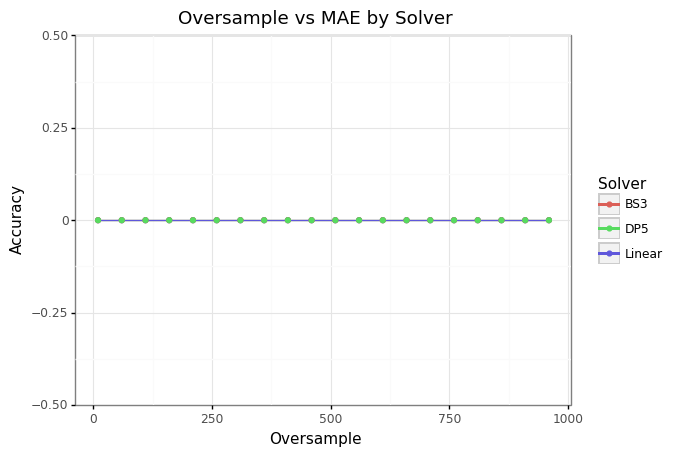

<ggplot: (8759716246495)>

In [13]:
(ggplot(odeint_oversample_resids, 
    aes(
        x="Oversample", 
        y="Accuracy", 
        color="Solver"
    ))
    + theme_bw()
    + geom_line()
    + geom_point()
    # + scale_y_log10()
    + ggtitle("Oversample vs MAE by Solver"))

In [11]:
odeint_oversample_resids["ymin"] =\
     odeint_oversample_resids["Time (s)"] -\
     odeint_oversample_resids["Time Var (s)"]

odeint_oversample_resids["ymax"] =\
     odeint_oversample_resids["Time (s)"] +\
     odeint_oversample_resids["Time Var (s)"]

/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/pandas-1.4.0rc0-py3.9-linux-x86_64.egg/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_errorbar : Removed 57 rows containing missing values.


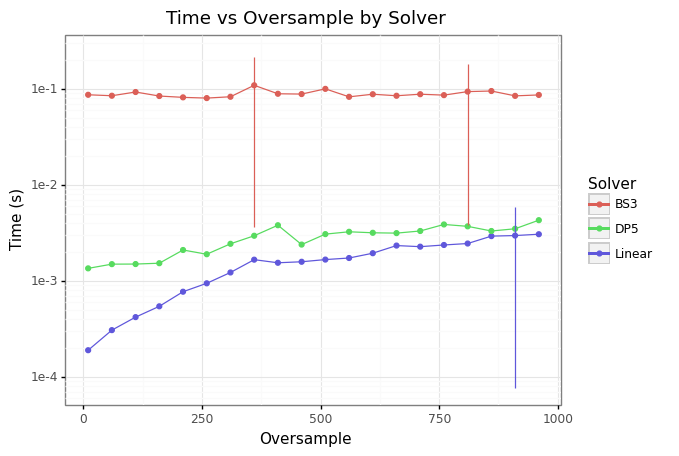

<ggplot: (8744964764938)>

In [12]:
(ggplot(odeint_oversample_resids, \
    aes(x="Oversample", y="Time (s)", ymin="ymin", ymax="ymax", color="Solver"))
    + theme_bw()
    + geom_line()
    + geom_point()
    + geom_errorbar()
    + scale_y_log10()
    + ggtitle("Time vs Oversample by Solver"))

Experimental analysis follows

In [15]:
results = {
    "module": [],
    "time": [],
    "type": []
}

for solver in odeint:# Iterating through the namespaces of odeint function 
    function_obj = generate_model(odeint[solver], 1008)

    r_profile = profile(function_obj.dc14_fine, parameters)
    results["module"].append(solver)
    results["time"].append(float(r_profile["average"]) * 1000)
    results["type"].append("odeint")

    g_profile = profile(jacrev(function_obj.log_likelihood), parameters)
    results["module"].append(solver)
    results["time"].append(float(g_profile["average"]) * 1000)
    results["type"].append("gradient")

    h_profile = profile(jacfwd(jacrev(function_obj.log_likelihood)), parameters)
    results["module"].append(solver)
    results["time"].append(float(h_profile["average"]) * 1000)
    results["type"].append("hessian")


ValueError: Reverse-mode differentiation does not work for lax.while_loop or lax.fori_loop. Try using lax.scan instead.

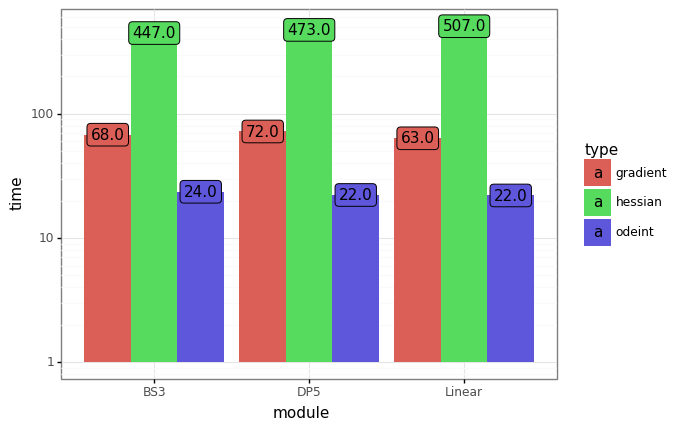

<ggplot: (8744790169935)>

In [14]:
results = DataFrame(results)  # Switching to a pandas data frame
(ggplot(results, aes(x="module", y="time", fill="type"))
    + geom_col(position="dodge")
    + geom_label(aes(label="round(time)"), position=position_dodge(width=0.9))
    + scale_y_log10()
    + theme_bw())